In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:

# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:

# We can view all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [9]:


# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [10]:


# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [11]:

# How many dates are recorded?
session.query(func.count(Measurement.date)).all()


[(19550,)]

In [12]:


earlieststr = session.query(Measurement.date).order_by(Measurement.date).first()
lateststr = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"Earliest: {earlieststr[0]} , Latest: {lateststr[0]}")




Earliest: 2010-01-01 , Latest: 2017-08-23


In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date

latestdate = dt.datetime.strptime(lateststr[0], '%Y-%m-%d')
querydate = dt.date(latestdate.year -1, latestdate.month, latestdate.day)
querydate

sel = [Measurement.date,Measurement.prcp]
queryresult = session.query(*sel).filter(Measurement.date >= querydate).all()

precipitation = pd.DataFrame(queryresult, columns=['Date','Precipitation'])
precipitation = precipitation.dropna(how='any') # clean up non value entries
precipitation = precipitation.sort_values(["Date"], ascending=True)
precipitation = precipitation.set_index("Date")
precipitation.head()

# Group by was not necessary
# groupbydate = df.groupby(["Date"])
# precipitation = pd.DataFrame({'Precipitation':groupbydate['Precipitation'].mean()})
# precipitation.head()


,Precipitation
Date,
2016-08-23,0.0
2016-08-23,0.5
2016-08-23,1.3
2016-08-23,17.8
2016-08-23,3.8


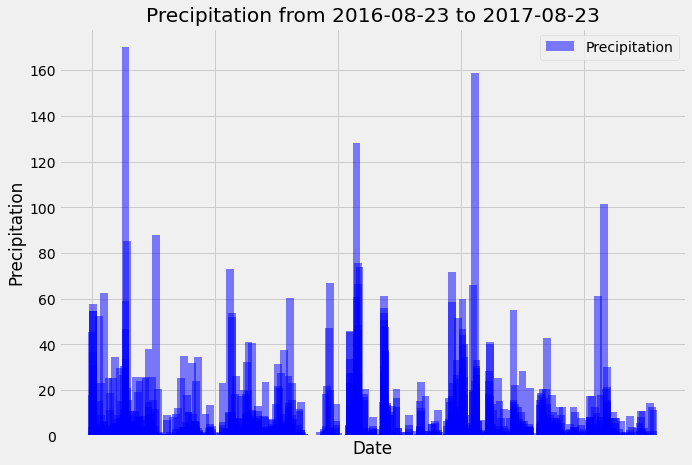

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data

xx = precipitation.index.tolist()
yy = precipitation['Precipitation'].tolist()

plt.figure(figsize=(10,7))
plt.bar(xx,yy,width = 5 ,color='b', alpha=0.5, align="center",label='Precipitation')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
major_ticks = np.arange(0,400,80)
plt.xticks(major_ticks)

plt.title(f"Precipitation from {querydate} to {lateststr[0]}")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.grid(which='major', axis='both', linestyle='-')
plt.legend()
plt.show()


In [17]:

# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation.describe()


,Precipitation
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


In [18]:


# Design a query to show how many stations are available in this dataset?
session.query(Station.id).count() # id is the primary key


9

In [19]:

# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [Measurement.station,func.count(Measurement.id)]
activestations = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()
activestations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:

# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

sel = [func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
mostactivestationdata = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).first()
mostactivestationdata



(12.2, 29.4, 22.03582251082252)

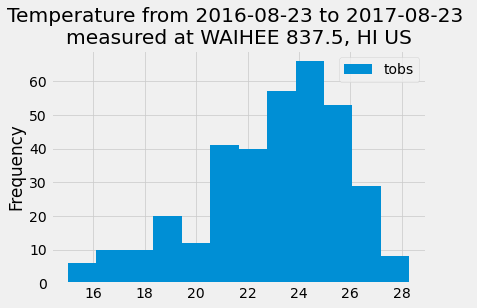

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

queryresult = session.query(Measurement.tobs).\
    filter(Measurement.station == activestations[0][0]).\
    filter(Measurement.date >= querydate).all()
temperatures = list(np.ravel(queryresult))

sel = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation]
queryresult = session.query(*sel).all()
stations_desc = pd.DataFrame(queryresult, columns=['Station','Name','Latitude','Longitude','Elevation'])

stationname = stations_desc.loc[stations_desc["Station"] == activestations[0][0],"Name"].tolist()[0]

# n, bins, patches = plt.hist(temperatures, bins=12,alpha=0.7, rwidth=1.0,label='tobs')
plt.hist(temperatures, bins=12,rwidth=1.0,label='tobs')
plt.grid(axis='both', alpha=0.75)
plt.ylabel('Frequency')
plt.title(f"Temperature from {querydate} to {lateststr[0]} \nmeasured at {stationname}")
plt.legend()
# maxfreq = n.max()
# plt.ylim(top=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)


In [22]:

# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))


[(16.7, 20.873214285714287, 23.3)]


In [23]:

# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
startdate = '2017-01-01'
enddate = '2017-01-07'
tempresult = calc_temps(startdate,enddate)[0]
tempresult


(16.7, 20.202439024390255, 23.3)

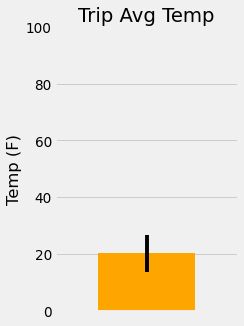

In [24]:

# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x_pos = [0]
y_pos = [tempresult[1]]
error = [(tempresult[2] - tempresult[0])]

w = 3
h = 5
d = 70
plt.figure(figsize=(w, h), dpi=d)
plt.bar(x_pos,y_pos,color='orange', yerr=error)
plt.xlim(-0.75,0.75)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.ylim(0, 100)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.grid(which='major', axis='x', linestyle='')
plt.grid(which='major', axis='y', linestyle='-')
plt.show()


In [25]:

# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# test= [('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31),
#        ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), 
#        ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), 
#        ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), 
#        ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), 
#        ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), 
#        ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), 
#        ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), 
#        ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]
# test = pd.DataFrame(test, columns=['Station','Name','Latitude','Longitude','Elevation','Prcp'])
# test

# startdate = '2017-01-01'
# enddate = '2017-01-07'

# sel = [Measurement.station,func.sum(Measurement.prcp)]
# queryresult = session.query(*sel).\
#     group_by(Measurement.station).\
#     filter(Measurement.date >= startdate).\
#     filter(Measurement.date <= enddate).all()
# #     order_by(func.sum(Measurement.prcp).desc()).all()
# stations_prec = pd.DataFrame(queryresult,columns=['Station','PrcpSum'])

# sel = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation]
# queryresult = session.query(*sel).all()
# stations_desc = pd.DataFrame(queryresult, columns=['Station','Name','Latitude','Longitude','Elevation'])

# stations = pd.merge(stations_desc,stations_prec, on="Station", how="left")
# stations = stations.sort_values("PrcpSum",ascending=False)
# # stations = stations.fillna(value = {'PrcpSum':0})
# stations = stations.reset_index(drop=True)
# stations

startdate = '2017-01-01'
enddate = '2017-01-07'

sel = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)]
queryresult = session.query(*sel).\
    filter(Station.station == Measurement.station).\
    group_by(Measurement.station).\
    filter(Measurement.date >= startdate).\
    filter(Measurement.date <= enddate).\
    order_by(func.sum(Measurement.prcp).desc()).\
    all()
  
stations = pd.DataFrame(queryresult, columns=['Station','Name','Latitude','Longitude','Elevation','PrcpSum'])
stations


,Station,Name,Latitude,Longitude,Elevation,PrcpSum
0,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,5.943,15.6
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,2.133,15.3
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,46.449,15.2
3,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,4.450,8.9
4,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,10.027,5.1
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,0.914,0.0


In [26]:

# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)
def daily_normals(date):
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")


     

[(16.7, 20.64230769230769, 25.0)]

In [27]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

startdate = '2018-01-01'
enddate = '2018-01-07'

# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date

dtobj = dt.datetime.strptime(startdate, '%Y-%m-%d')
enddtobj = dt.datetime.strptime(enddate, '%Y-%m-%d')

tripdates = []
normals =[]
while (dtobj <= enddtobj):
    tripdates.append(dt.datetime.strftime(dtobj,'%Y-%m-%d'))
    datestr = dt.datetime.strftime(dtobj,'%m-%d')
    normals.append(list(np.ravel(daily_normals(datestr))))
    dtobj = dtobj + dt.timedelta(days = 1)

normals


[[16.7, 20.64230769230769, 25.0],
 [15.6, 20.781132075471696, 25.0],
 [16.7, 20.50363636363636, 25.0],
 [14.4, 21.112280701754386, 24.4],
 [13.3, 19.976785714285718, 24.4],
 [16.1, 20.53333333333334, 24.4],
 [13.9, 20.301754385964912, 24.4]]